# PMDA

PMDA implements a simple map-reduce scheme for parallel trajectory analysis for MDAnalysis. The trajectory is partitioned into blocks and analysis is performed separately and in parallel on each block (“map”). The results from each block are gathered and combined (“reduce”). PMDA contains a number of pre-defined analysis classes that are modelled after functionality in MDAnalysis.analysis and that can be used right away. However, often it can be almost as easy to write your own parallel class.

In [ ]:
# %load parallel.py
# vim: tabstop=4 expandtab shiftwidth=4 softtabstop=4
#
# PMDA
# Copyright (c) 2017 The MDAnalysis Development Team and contributors
# (see the file AUTHORS for the full list of names)
#
# Released under the GNU Public Licence, v2 or any higher version
"""
Parallel Analysis building blocks --- :mod:`pmda.parallel`
==========================================================

A collection of useful building blocks for creating Analysis
classes.

"""
from __future__ import absolute_import, division
from contextlib import contextmanager
import warnings

from six.moves import range

import MDAnalysis as mda
from dask.delayed import delayed
import dask
import dask.distributed
from joblib import cpu_count
import numpy as np

from .util import timeit, make_balanced_slices


class Timing(object):
    """
    store various timeing results of obtained during a parallel analysis run
    """

    def __init__(self, io, compute, total, universe, prepare, conclude):
        self._io = io
        self._compute = compute
        self._total = total
        self._cumulate = np.sum(io) + np.sum(compute)
        self._universe = universe
        self._prepare = prepare
        self._conclude = conclude

    @property
    def io(self):
        """io time per frame"""
        return self._io

    @property
    def compute(self):
        """compute time per frame"""
        return self._compute

    @property
    def total(self):
        """wall time"""
        return self._total

    @property
    def cumulate_time(self):
        """cumulative time of io and compute for each frame. This isn't equal to
        `self.total / n_jobs` because `self.total` also includes the scheduler
        overhead

        """
        return self._cumulate

    @property
    def universe(self):
        """time to create a universe for each block"""
        return self._universe

    @property
    def prepare(self):
        """time to prepare"""
        return self._prepare

    @property
    def conclude(self):
        """time to conclude"""
        return self._conclude


class ParallelAnalysisBase(object):
    """Base class for defining parallel multi frame analysis

    The class it is designed as a template for creating multiframe analyses.
    This class will automatically take care of setting up the trajectory
    reader for iterating in parallel.

    To parallelize the analysis ``ParallelAnalysisBase`` separates the
    trajectory into work blocks containing multiple frames. The number of
    blocks is equal to the number of available cores or dask workers. This
    minimizes the number of python processes that are started during a
    calculation. Accumulation of frames within a block happens in the
    `self._reduce` function. A consequence when using dask is that adding
    additional workers during a computation will not result in an reduction
    of run-time.


    To define a new Analysis,
    :class:`~pmda.parallel.ParallelAnalysisBase` needs to be
    subclassed and
    :meth:`~pmda.parallel.ParallelAnalysisBase._single_frame` and
    :meth:`~pmda.parallel.ParallelAnalysisBase._conclude` must be
    defined. It is also possible to define
    :meth:`~~pmda.parallel.ParallelAnalysisBase._prepare` for
    pre-processing and :meth:`~~pmda.parallel.ParallelAnalysisBase._reduce`
    for custom reduce operation on the work blocks. See the example below.

    .. code-block:: python

       class NewAnalysis(ParallelAnalysisBase):
           def __init__(self, atomgroup, parameter):
               self._ag = atomgroup
               super(NewAnalysis, self).__init__(atomgroup.universe,
                                                 self._ag)

           def _single_frame(self, ts, agroups):
               # REQUIRED
               # called for every frame. ``ts`` contains the current time step
               # and ``agroups`` a tuple of atomgroups that are updated to the
               # current frame. Return result of `some_function` for a single
               # frame
               return some_function(agroups[0], self._parameter)

           def _conclude(self):
               # REQUIRED
               # Called once iteration on the trajectory is finished. Results
               # for each frame are stored in ``self._results`` in a per block
               # basis. Here those results should be moved and reshaped into a
               # sensible new variable.
               self.results = np.hstack(self._results)
               # Apply normalisation and averaging to results here if wanted.
               self.results /= np.sum(self.results

           @staticmethod
           def _reduce(res, result_single_frame):
               # NOT REQUIRED
               # Called for every frame. ``res`` contains all the results
               # before current time step, and ``result_single_frame`` is the
               # result of self._single_frame for the current time step. The
               # return value is the updated ``res``. The default is to append
               # results to a python list. This approach is sufficient for
               # time-series data.
               res.append(results_single_frame)
               # This is not suitable for every analysis. To add results over
               # multiple frames this function can be overwritten. The default
               # value for ``res`` is an empty list. Here we change the type to
               # the return type of `self._single_frame`. Afterwards we can
               # safely use addition to accumulate the results.
               if res == []:
                   res = result_single_frame
               else:
                   res += result_single_frame
               # If you overwrite this function *always* return the updated
               # ``res`` at the end.
               return res

    Afterwards the new analysis can be run like this.

    .. code-block:: python

       na = NewAnalysis(u.select_atoms('name CA'), 35).run()
       print(na.result)

    """

    def __init__(self, universe, atomgroups):
        """Parameters
        ----------
        Universe : :class:`~MDAnalysis.core.groups.Universe`
            a :class:`MDAnalysis.core.groups.Universe` (the
            `atomgroups` must belong to this Universe)

        atomgroups : tuple of :class:`~MDAnalysis.core.groups.AtomGroup`
            atomgroups that are iterated in parallel

        Attributes
        ----------
        _results : list
            The raw data from each process are stored as a list of
            lists, with each sublist containing the return values from
            :meth:`pmda.parallel.ParallelAnalysisBase._single_frame`.

        """
        self._trajectory = universe.trajectory
        self._top = universe.filename
        self._traj = universe.trajectory.filename
        self._indices = [ag.indices for ag in atomgroups]

    @contextmanager
    def readonly_attributes(self):
        """Set the attributes of this class to be read only

        Useful to avoid the class being modified when passing it around.

        To be used as a context manager::

          with analysis.readonly_attributes():
              some_function(analysis)

        """
        self._attr_lock = True
        yield
        self._attr_lock = False

    def __setattr__(self, key, val):
        # guards to stop people assigning to self when they shouldn't
        # if locked, the only attribute you can modify is _attr_lock
        # if self._attr_lock isn't set, default to unlocked
        if key == '_attr_lock' or not getattr(self, '_attr_lock', False):
            super(ParallelAnalysisBase, self).__setattr__(key, val)
        else:
            # raise HalError("I'm sorry Dave, I'm afraid I can't do that")
            raise AttributeError("Can't set attribute at this time")

    def _conclude(self):
        """Finalise the results you've gathered.

        Called at the end of the run() method to finish everything up.

        In general this method should unpack :attr:`self._results` to
        sensible variables.

        """
        pass

    def _prepare(self):
        """additional preparation to run"""
        pass

    def _single_frame(self, ts, atomgroups):
        """Perform computation on a single trajectory frame.

        Must return computed values as a list. You can only **read**
        from member variables stored in ``self``. Changing them during
        a run will result in undefined behavior. `ts` and any of the
        atomgroups can be changed (but changes will be overwritten
        when the next time step is read).

        Parameters
        ----------
        ts : :class:`~MDAnalysis.coordinates.base.Timestep`
            The current coordinate frame (time step) in the
            trajectory.
        atomgroups : tuple
            Tuple of :class:`~MDAnalysis.core.groups.AtomGroup`
            instances that are updated to the current frame.

        Returns
        -------
        values : anything
            The output from the computation over a single frame must
            be returned. The `value` will be added to a list for each
            block and the list of blocks is stored as :attr:`_results`
            before :meth:`_conclude` is run. In order to simplify
            processing, the `values` should be "simple" shallow data
            structures such as arrays or lists of numbers.

        """
        raise NotImplementedError

    def run(self,
            start=None,
            stop=None,
            step=None,
            n_jobs=1,
            n_blocks=None):
        """Perform the calculation

        Parameters
        ----------
        start : int, optional
            start frame of analysis
        stop : int, optional
            stop frame of analysis
        step : int, optional
            number of frames to skip between each analysed frame
        n_jobs : int, optional
            number of jobs to start, if `-1` use number of logical cpu cores.
            This argument will be ignored when the distributed scheduler is
            used
        n_blocks : int, optional
            number of blocks to divide trajectory into. If ``None`` set equal
            to n_jobs or number of available workers in scheduler.

        """
        # are we using a distributed scheduler or should we use
        # multiprocessing?
        scheduler = dask.config.get('scheduler', None)
        if scheduler is None:
            # maybe we can grab a global worker
            try:
                scheduler = dask.distributed.worker.get_client()
            except ValueError:
                pass

        if n_jobs == -1:
            n_jobs = cpu_count()

        # we could not find a global scheduler to use and we ask for a single
        # job. Therefore we run this on the single threaded scheduler for
        # debugging.
        if scheduler is None and n_jobs == 1:
            scheduler = 'single-threaded'

        # fall back to multiprocessing, we tried everything
        if scheduler is None:
            scheduler = 'multiprocessing'

        if n_blocks is None:
            if scheduler == 'multiprocessing':
                n_blocks = n_jobs
            elif isinstance(scheduler, dask.distributed.Client):
                n_blocks = len(scheduler.ncores())
            else:
                n_blocks = 1
                warnings.warn(
                    "Couldn't guess ideal number of blocks from scheduler. "
                    "Setting n_blocks=1. "
                    "Please provide `n_blocks` in call to method.")

        scheduler_kwargs = {'scheduler': scheduler}
        if scheduler == 'multiprocessing':
            scheduler_kwargs['num_workers'] = n_jobs

        start, stop, step = self._trajectory.check_slice_indices(
            start, stop, step)
        n_frames = len(range(start, stop, step))

        if n_frames == 0:
            warnings.warn("run() analyses no frames: check start/stop/step")
        if n_frames < n_blocks:
            warnings.warn("run() uses more blocks than frames: "
                          "decrease n_blocks")

        slices = make_balanced_slices(n_frames, n_blocks,
                                      start=start, stop=stop, step=step)

        with timeit() as total:
            with timeit() as prepare:
                self._prepare()
            time_prepare = prepare.elapsed
            blocks = []
            with self.readonly_attributes():
                for bslice in slices:
                    task = delayed(
                        self._dask_helper, pure=False)(
                            bslice,
                            self._indices,
                            self._top,
                            self._traj, )
                    blocks.append(task)
                blocks = delayed(blocks)
                res = blocks.compute(**scheduler_kwargs)
            # hack to handle n_frames == 0 in this framework
            if len(res) == 0:
                # everything else wants list of block tuples
                res = [([], [], [], 0)]
            self._results = np.asarray([el[0] for el in res])
            with timeit() as conclude:
                self._conclude()

        self.timing = Timing(
            np.hstack([el[1] for el in res]),
            np.hstack([el[2] for el in res]), total.elapsed,
            np.array([el[3] for el in res]), time_prepare, conclude.elapsed)
        return self

    def _dask_helper(self, bslice, indices, top, traj):
        """helper function to actually setup dask graph"""
        with timeit() as b_universe:
            u = mda.Universe(top, traj)
            agroups = [u.atoms[idx] for idx in indices]

        res = []
        times_io = []
        times_compute = []
        # NOTE: bslice.stop cannot be None! Always make sure
        #       that it comes from  _trajectory.check_slice_indices()!
        for i in range(bslice.start, bslice.stop, bslice.step):
            with timeit() as b_io:
                # explicit instead of 'for ts in u.trajectory[bslice]'
                # so that we can get accurate timing.
                ts = u.trajectory[i]
            with timeit() as b_compute:
                res = self._reduce(res, self._single_frame(ts, agroups))
            times_io.append(b_io.elapsed)
            times_compute.append(b_compute.elapsed)

        return np.asarray(res), np.asarray(times_io), np.asarray(
            times_compute), b_universe.elapsed

    @staticmethod
    def _reduce(res, result_single_frame):
        """ 'append' action for a time series"""
        res.append(result_single_frame)
        return res


# PMDA benchmark

Test system: 10000-frame trajectory of a system which contains 42469 water molecules and 149 sodium ions.
We test the performance of pmda.rdf by calculating RDFs between sodium ions and oxygen atoms of water.


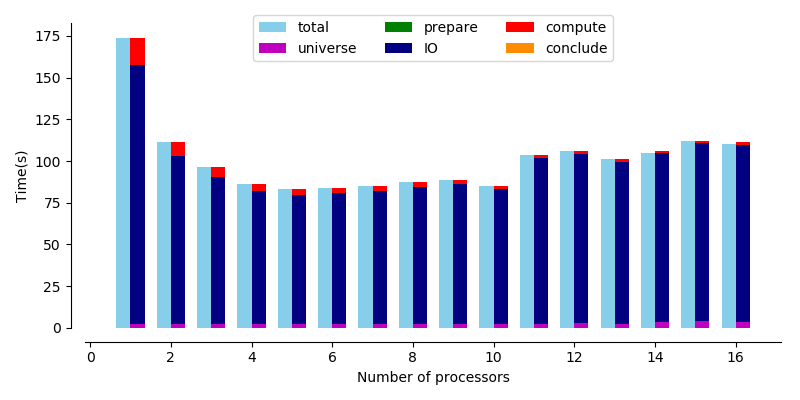

In [3]:
from IPython.core.display import Image
Image('bcmk.png')

# Tutorial

This tutorial introduces basic use of PMDA:

- Pre-defined parallel analysis tasks.
- Building new parallel analysis modules with the `pmda.custom.AnalysisFromFunction`.
- Building new parallel analysis with `pmda.parallel.ParallelAnalysisBase`.

Here, we use pmda to perform a protein-ion binding analysis.

## Pre-defined parallel analysis task pmda.rms

### rmsd calculation
We can use the pmda.rms to calculate RMSD(t) of the C-alpha atoms. The process is similar to using MDAnalysis.rms. We take the initial frame of the trajectory as a reference. 

## Building new parallel analysis modules with the pmda.custom.AnalysisFromFunction

One easy way to check whether sodium ions are binded to the protein is to look at the coordinates of sodium ions. Here, we use `pmda.custom.AnalysisFromFunction` to build a new parallel analysis module to gather the coordinates of each timestep.

In [ ]:
# %load ~/pmda/pmda/custom.py
# vim: tabstop=4 expandtab shiftwidth=4 softtabstop=4
#
# PMDA
# Copyright (c) 2017 The MDAnalysis Development Team and contributors
# (see the file AUTHORS for the full list of names)
#
# Released under the GNU Public Licence, v2 or any higher version
"""
Parallel Analysis helper --- :mod:`pmda.custom`
===============================================

This module contains the class `AnalysisFromFunction` and the decorator
`analysis_class`. Both can be used to generate custom analysis classes that can
be run in parallel from functions that take one or more atom groups from the
same universe and return a value.

"""
from __future__ import absolute_import

from MDAnalysis.core.groups import AtomGroup
from MDAnalysis.core.universe import Universe
from MDAnalysis.coordinates.base import ProtoReader
import numpy as np

from .parallel import ParallelAnalysisBase


class AnalysisFromFunction(ParallelAnalysisBase):
    """
    Create an analysis from a function working on AtomGroups

    The function that is used

    Attributes
    ----------
    results : ndarray
        results of calculation are stored after call to ``run``

    Example
    -------
    >>> # Create a new function to analyze a single frame
    >>> def rotation_matrix(mobile, ref):
    >>>     return mda.analysis.align.rotation_matrix(mobile, ref)[0]
    >>> # now run an analysis using the standalone function
    >>> rot = AnalysisFromFunction(rotation_matrix,
                                   trajectory, mobile, ref).run()
    >>> print(rot.results)

    Raises
    ------
    ValueError : if ``function`` has the same kwargs as ``BaseAnalysis``

    See Also
    --------
    analysis_class
    """

    def __init__(self, function, universe, *args, **kwargs):
        """Parameters
        ----------
        function : callable
            function to evaluate at each frame. The first arguments are assumed
            to be 'mobile' Atomgroups if they belong to the same universe. All
            other Atomgroups are assumed to be reference. Here 'mobile' means
            they will be iterated over.
        Universe : :class:`~MDAnalysis.core.groups.Universe`
            a :class:`MDAnalysis.core.groups.Universe` (the
            `atomgroups` must belong to this Universe)
        *args : list
           arguments for ``function``
        **kwargs : dict
           keyword arguments for ``function``. keyword arguments with name
           'universe' or 'atomgroups' will be ignored! Mobile atomgroups to
           analyze can not be passed as keyword arguments currently.

        """

        self.function = function

        # collect all atomgroups with the same trajectory object as universe
        trajectory = universe.trajectory
        arg_ags = []
        self.other_args = []
        for arg in args:
            if isinstance(arg,
                          AtomGroup) and arg.universe.trajectory == trajectory:
                arg_ags.append(arg)
            else:
                self.other_args.append(arg)

        super(AnalysisFromFunction, self).__init__(universe, arg_ags)
        self.kwargs = kwargs

    def _prepare(self):
        self.results = []

    def _single_frame(self, ts, atomgroups):
        args = atomgroups + self.other_args
        return self.function(*args, **self.kwargs)

    def _conclude(self):
        self.results = np.vstack(self._results)


def analysis_class(function):
    """Transform a function operating on a single frame to an analysis class

    Parameters
    ----------
    function : callable
        The function that can analyze a single or more atomgroups. It is always
        assumed that the mobile atomgroups (which will be iterated over) come
        first. All atomgroups that come directly after the first that are part
        of the same universe will iterated over

    Returns
    -------
    A new AnalysisClass with function as analysis

    Example
    -------
    For an usage in a library we recommend the following style:

    >>> def rotation_matrix(mobile, ref):
    >>>     return mda.analysis.align.rotation_matrix(mobile, ref)[0]
    >>> RotationMatrix = analysis_class(rotation_matrix)

    It can also be used as a decorator:

    >>> @analysis_class
    >>> def RotationMatrix(mobile, ref):
    >>>     return mda.analysis.align.rotation_matrix(mobile, ref)[0]

    >>> rot = RotationMatrix(u.trajectory, mobile, ref, step=2).run()
    >>> print(rot.results)

    See Also
    --------
    AnalysisFromFunction

    """

    class WrapperClass(AnalysisFromFunction):
        """Custom Analysis Function"""

        def __init__(self, trajectory=None, *args, **kwargs):
            if not (isinstance(trajectory, ProtoReader) or isinstance(
                    trajectory, Universe)):
                print(type(trajectory))
                raise ValueError(
                    "First argument needs to be an MDAnalysis reader object.")
            super(WrapperClass, self).__init__(function, trajectory, *args,
                                               **kwargs)

    return WrapperClass


## Pre-defined parallel analysis task pmda.rdf


### RDF calculatoin

RDF(radial distribution function) describes how density varies as a function of distance from a reference particle. RDF can provide important information such as the most likely distance between ligand and binding sites. between ligand and the structure of the solvation shells of a ligand in binding sites.
Here, we calculate the RDF between sodium ions and oxygen atoms of aspartates in NhaA using pmda.rdf.

## Building new parallel analysis with pmda.parallel.ParallelAnalysisBase.